# Using Machine Learning for Structural Identification
This notebook provides a demonstration of how a simple set of descriptors computed by freud can be coupled with machine learning for structural identification. The set of descriptors used here are not enough to identify complex crystal structures, but this notebook provides an introduction. For a more powerful set of descriptors, see the paper [Machine learning for crystal identification and discovery (Spellings 2018)](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.16157) and the library [pythia](https://github.com/glotzerlab/pythia), both of which use freud for their computations.

In [1]:
import freud
import numpy as np
import pandas as pd
import util

We generate sample body-centered cubic, face-centered cubic, and simple cubic structures. Each structure has at least 4000 particles.

In [2]:
N = 4000
noise = 0.1
n = round((N/2)**(1/3))
bcc_box, bcc_positions = util.make_bcc(nx=n, ny=n, nz=n, noise=noise)
n = round((N/4)**(1/3))
fcc_box, fcc_positions = util.make_fcc(nx=n, ny=n, nz=n, noise=noise)
n = round((N/1)**(1/3))
sc_box, sc_positions = util.make_sc(nx=n, ny=n, nz=n, noise=noise)
print('bcc has', len(bcc_positions), 'particles.')
print('fcc has', len(fcc_positions), 'particles.')
print('sc has', len(sc_positions), 'particles.')

bcc has 4394 particles.
fcc has 4000 particles.
sc has 4096 particles.


In [3]:
import plato.draw.pythreejs as draw
def draw_system(positions):
    radii = 0.5 * np.ones(len(positions))
    colors = [[0.5, 0.5, 0.5, 1]] * len(positions)
    draw.Scene(draw.Spheres(positions=positions, radii=radii, colors=colors)).show()

In [4]:
import matplotlib.pyplot as plt

In [5]:
def get_features(box, positions, structure):
    voro = freud.voronoi.Voronoi(box, buff=max(box.L)/2)
    voro.computeNeighbors(positions)
    nlist = voro.nlist
    nlist.filter(nlist.weights > 0.1)
    features = {}
    for l in [4, 6, 8, 10, 12]:
        ql = freud.order.LocalQl(box, rmax=max(box.L)/2, l=l)
        ql.compute(positions, nlist)
        Ql = ql.Ql.copy()
        features['q{}'.format(l)] = Ql
        
    return features

In [6]:
structures = {}
structures['sc'] = get_features(sc_box, sc_positions, 'sc')
structures['bcc'] = get_features(bcc_box, bcc_positions, 'bcc')
structures['fcc'] = get_features(fcc_box, fcc_positions, 'fcc')

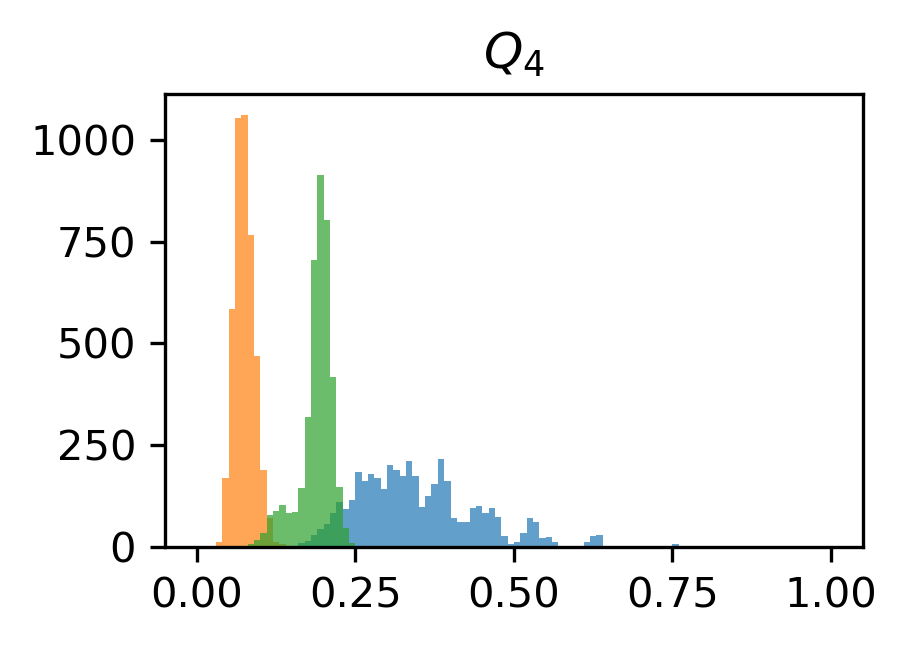

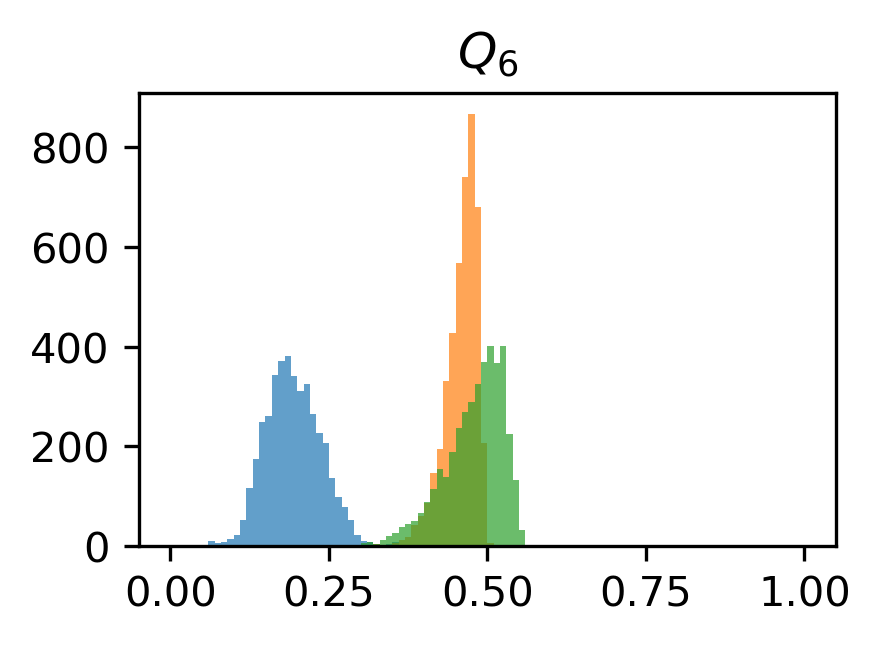

In [7]:
for l in [4, 6]:
    plt.figure(figsize=(3, 2), dpi=300)
    plt.hist(structures['sc']['q{}'.format(l)], range=(0, 1), bins=100, label='sc', alpha=0.7)
    plt.hist(structures['bcc']['q{}'.format(l)], range=(0, 1), bins=100, label='bcc', alpha=0.7)
    plt.hist(structures['fcc']['q{}'.format(l)], range=(0, 1), bins=100, label='fcc', alpha=0.7)
    plt.title(r'$Q_{{{l}}}$'.format(l=l))
    plt.show()

In [8]:
structure_dfs = {}
for i, structure in enumerate(structures):
    df = pd.DataFrame.from_dict(structures[structure])
    df['class'] = i
    structure_dfs[structure] = df

In [9]:
df = pd.concat(structure_dfs.values()).reset_index(drop=True)

In [10]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [11]:
X = df.drop('class', axis=1).values
X = normalize(X)
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
print('Score:', svm.score(X_test, y_test))

/Users/bdice/miniconda3/envs/dice/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.9856865599223678


In [12]:
from umap import UMAP

In [13]:
umap = UMAP(random_state=42)

X_reduced = umap.fit_transform(X)

In [14]:
import matplotlib.cm

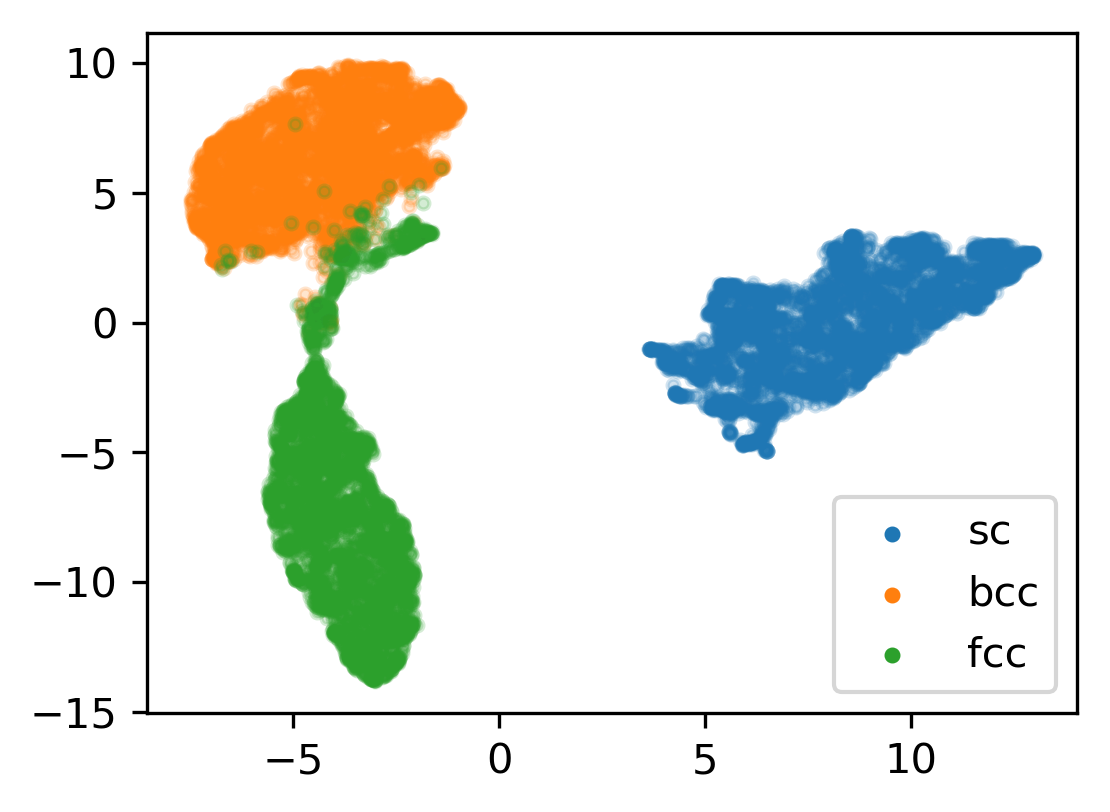

In [15]:
plt.figure(figsize=(4, 3), dpi=300)
for i in range(max(y) + 1):
    indices = np.where(y == i)[0]
    plt.scatter(X_reduced[indices, 0], X_reduced[indices, 1], color=matplotlib.cm.tab10(i), s=8, alpha=0.2, label=list(structures.keys())[i])
plt.legend()
for lh in plt.legend().legendHandles:
    lh.set_alpha(1)
plt.show()